In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [27]:
METRIC = 'long10'
INSTRUMENT = 'EUR_USD'
GRANULARITY = 1
IMAGE_DIR = 'images/%s_%s_%s/' % (GRANULARITY, INSTRUMENT, METRIC)
TRAIN_DIR = IMAGE_DIR + 'train'
TEST_DIR = IMAGE_DIR + 'test'

batch_size = 32
img_height = 434
img_width = 422

In [28]:
# load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=(img_height, img_width), validation_split=0.2,
    subset="training", seed=123, batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=(img_height, img_width), validation_split=0.2,
    subset="validation", seed=123, batch_size=batch_size
)

Found 18252 files belonging to 2 classes.
Using 14602 files for training.
Found 18252 files belonging to 2 classes.
Using 3650 files for validation.


In [55]:
# calculate class weights
total = 0
count_1 = 0
for batch in train_ds:
    total += len(batch[1])
    count_1 += sum(batch[1].numpy())

class_weight = {
    0: (1 / (total - count_1)) * (total / 2.0),
    1: (1 / count_1) * (total / 2.0)
} 

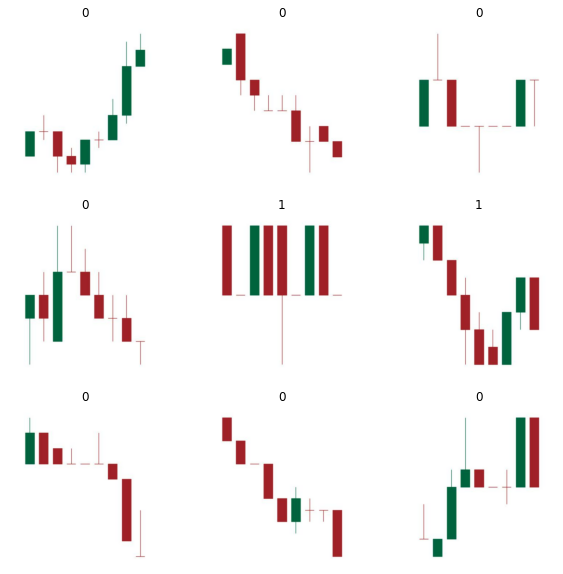

In [23]:
# visualize data
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
# standardize data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2021-11-29 19:40:47.135312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 130 of 1000
2021-11-29 19:40:57.116793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 265 of 1000
2021-11-29 19:41:07.153641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 400 of 1000
2021-11-29 19:41:11.092999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


0.0 1.0


In [29]:
# initialize model
num_classes = 2

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [32]:
# train model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    class_weight=class_weight
)

Epoch 1/10
457/457 [==============================] - 825s 2s/step - loss: 0.7440 - accuracy: 0.5790 - val_loss: 0.6788 - val_accuracy: 0.5860
Epoch 2/10
457/457 [==============================] - 833s 2s/step - loss: 0.6792 - accuracy: 0.5825 - val_loss: 0.6856 - val_accuracy: 0.5860
Epoch 3/10
457/457 [==============================] - 830s 2s/step - loss: 0.6766 - accuracy: 0.5844 - val_loss: 0.6870 - val_accuracy: 0.5625
Epoch 4/10
186/457 [===========>..................] - ETA: 8:03 - loss: 0.6742 - accuracy: 0.5927

KeyboardInterrupt: 

In [ ]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()